## Mount Notebook to Google Colab Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Change Directory

In [2]:
cd /content/drive/MyDrive/Deep_Learning_Assignment_May_2021/Deep_Learning_Assignment

/content/drive/MyDrive/Deep_Learning_Assignment_May_2021/Deep_Learning_Assignment


## Load Libraries

In [3]:
import os
import math
import matplotlib
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch, torchvision
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.utils.data as data_utils

from PIL import Image, ImageOps
from torchsummary import summary
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix

## Create Dataset Classes
This is to transform any dataset we import into a class that can be processed by our model


### 1. Fashion MNIST Dataset

In [4]:
###############################
# code by Lee Hao Jie  #
###############################
class FashionMNIST(Dataset):
    
    def __init__(self, root = ".", train = True, download=False, transform=None, num_samples = None):
        self.classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        self.num_classes = len(self.classes)            
        self.__dataset = torchvision.datasets.FashionMNIST(root=root, train=train, download=download, transform=transform)
        self.__num_samples = min(num_samples, len(self.__dataset)) if num_samples is not None else len(self.__dataset)
                       
    def __len__(self):
        return self.__num_samples
    
    def __getitem__(self, idx):            
        return self.__dataset[idx]

### 2. Fashion Product Small Dataset

In [5]:
###############################
# code by Tan Xi En  #
###############################
# We try to work on other fashion dataset but
# it take too long for collab to process the dataset

class FashionProductSmallDataset(Dataset):
    def __init__(self, csv_name, image_path, transform=None):
        df = pd.read_csv(csv_name)
        self.data = []
        self.labels = []
        self.classes = sorted(df.articleType.unique())
        self.transform = transform

        for class_id, cls in enumerate(self.classes):
            cls_folder = os.path.join(image_path, cls)
            for img_name in os.listdir(cls_folder):
                self.data.append(os.path.join(cls_folder, img_name))
                self.labels.append(class_id)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = Image.open(self.data[idx])
        if self.transform is not None:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

## Fetch Dataset

In [6]:
dataset = FashionMNIST(root=".", download= True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Original Image

In [7]:
def show_image(img):
    plt.imshow (img, cmap = matplotlib.cm.gray, interpolation = 'nearest')

(28, 28)


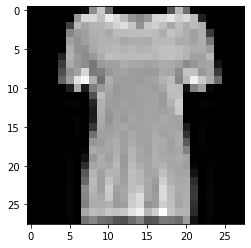

In [8]:
idx = 10
img, label = dataset[idx]

show_image(img)
print(img.size)

## Transformation Pipeline
* Resize image from (28,28) to Standard Image Size (32, 32)
* Convert Tensor Pil Image to Tensor
* Normalize Image to Tensor Float
* _Data Augmentation (Extra): Random Crop_
* _Data Augmentation (Extra): Random Horizontal Flip_


In [9]:
###############################
# code by Lee Hao Jie  #
###############################

fashion_MNIST_transform= transforms.Compose([ 
    transforms.Resize(32),       
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
])

In [10]:
###############################
# code by Tan Xi En  #
###############################

fashion_product_small_transform = transforms.Compose([
    transforms.Lambda(lambda img: ImageOps.grayscale(img)),                                              
    transforms.Resize(32),
    transforms.RandomCrop(28),                            
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
])

## Load Dataset, Split Dataset, Batch Loader

### Fashion MNIST Dataset

In [11]:
###############################
# code by Lee Hao Jie  #
###############################

## Split dataset into trainset and test set

trainset = FashionMNIST(root=".",train=True, download= True, transform = fashion_MNIST_transform)
testset = FashionMNIST(root=".",train=False, download= True, transform = fashion_MNIST_transform)

## BatchLoader
trainloader = DataLoader(trainset, batch_size = 20, shuffle = True, num_workers = 2)
testloader = DataLoader(testset, batch_size = 20, shuffle = True, num_workers = 2)

### Fashion Product Small Dataset

In [12]:
###############################
# code by Tan Xi En  #
###############################

# csv_name = "./fashion_product_small_img/fashion_image_small.csv"
# image_path = "./fashion_product_small_img/kaggle_fashion_small/"
# dataset = FashionProductSmallDataset(csv_name, image_path, transform = fashion_product_small_transform)

# ## Split Dataset into Train Set and Testing Set
# x = math.ceil(len(dataset) * 0.8)
# y = len(dataset) - x
# trainset, testset = torch.utils.data.random_split(dataset, [x, y])

# ## BatchLoader
# trainloader = DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)
# testloader = DataLoader(testset, batch_size = 4, shuffle = True, num_workers = 2)

## Global Variables

In [13]:
###############################
# code by Lee Hao Jie  #
###############################
lr = 0.001
momentum = 0.9
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
file_dir = "Models"
num_of_class = len(trainset.classes)
num_epoch = 10

## Train Function

#### Train Pipeline:

* Optimizer => Used to update parameters after forward-backward Propagation
* Loss Function => Used to update the direction of the gradient
* The following train Model uses Gradient Descent algorithm. The gradient descent algorithm has the following pipeline.
  * Forward Propagation
  * Update Gradient to backwards
  * Backward Propagation
* For each epoch, the training loss and the test accuracy is recorded and stored for analysis purpose.

The save Function Records:
* Model Parameters
* Optimizer Parameters
* Last Epoch
* Train Loss for Each Epoch
* Test Accuracy for Each Epoch

In [14]:
##################################################
# code by Lee Hao Jie and Tan Xi En  #
##################################################
# This train function will save model based on file_dir and file_name
# determine by user and save the train loss and test accuracy in .pt file 

def train(model, trainloader, testloader, optimizer, file_dir, file_name, device, num_epoch=25, loss_iter=250, verbose=True):

    history_train_loss, history_train_accuracy = [], []
    loss_iterations = int(np.ceil(len(trainloader)/loss_iter))

    # set to training mode
    model.train()

    # train the network
    for e in range(num_epoch):
        running_loss, running_count, train_loss = 0.0, 0.0, 0
        for i, (inputs, labels) in enumerate(trainloader):
            optimizer.zero_grad()

            inputs = inputs.to(device)
            labels = labels.to(device)

            outs = model(inputs)
            loss = F.cross_entropy(outs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_count += 1
            train_loss = 0

            if i % loss_iterations == loss_iterations - 1 or i == len(trainloader) - 1:
                train_loss = running_loss / running_count
                running_loss, running_count = 0.0, 0.0
                if verbose:
                    print(f'[Epoch {e+1:2d}/{num_epoch:d} Iter {i+1:5d}/{len(trainloader)}]: train_loss = {train_loss:.4f}')

        # Train Loss for Each Epoch
        history_train_loss.append(train_loss)

        # Train Accuracy for Each Epoch
        running_corrects = 0
        for inputs, targets in testloader:

            # transfer to the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # disable gradient computation
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                running_corrects += (targets == predicted).double().sum()

        history_train_accuracy.append(
            running_corrects/len(testloader.dataset)*100.0)

        # save the model(done by Tan Xi En)
        checkpoint_file = f'./{file_dir}/{file_name}.pt'
        torch.save({
          "epoch": num_epoch,
          "model_state_dict": model.state_dict(),
          "optimizer_state_dict": optimizer.state_dict(),
          "history_train_loss": history_train_loss,
          "history_train_accuracy": history_train_accuracy
        }, checkpoint_file)


## Evaluate Model Performance

In [15]:
###############################
# code by Lee Hao Jie  #
###############################

def evaluate(model, testloader, device):

    # set to evaluation mode
    model.eval()

    # running_correct
    running_corrects = 0

    # Repeat for all batch data in the test set
    for inputs, targets in testloader:

        # transfer to the GPU
        inputs = inputs.to(device)
        targets = targets.to(device)

        # # disable gradient computation
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            running_corrects += (targets == predicted).double().sum()

    return 100*running_corrects/len(testloader.dataset)

## 3. LeNet Model (Done by Yikanin Yit)

![LeNet Model](https://drive.google.com/uc?id=19rKcKXQ2S6k7xbMWFumWCYnYyRbcGskH)

In [16]:
###############################
# code by Yikanin Yit  #
###############################

class LeNet5(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5,stride=1)
    self.pool1 = nn.AvgPool2d(2,2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5,stride=1)
    self.pool2 = nn.AvgPool2d(2,2)

    self.fc1 = nn.Linear(in_features=400, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.out = nn.Linear(in_features=84, out_features=10)

  # define forward function
  def forward(self, t):
    # conv 1
    t = torch.tanh(self.conv1(t))
    t = torch.tanh(self.pool1(t))

    # conv 2
    t = torch.tanh(self.conv2(t))
    t = torch.tanh(self.pool2(t))

    # fc1
    t = t.view(-1,400)
    t = torch.tanh(self.fc1(t))

    # fc2
    t = torch.tanh(self.fc2(t))
    
    # output
    t = self.out(t)
    # don't need softmax here since we'll use cross-entropy as activation.

    return t

## 4. Squeeze Excitation (SE) ResNet Model (Done by Lee Hao Jie)

![Squeeze Excitation (SE) ResNet Model](https://drive.google.com/uc?id=1jKqW1JX9ErqomwZkFSIMNhbZoshL25On)

Source Link: https://github.com/moskomule/senet.pytorch/blob/master/senet/se_module.py


In [17]:
###############################
# code by Lee Hao Jie  #
###############################

def conv_block(in_c,out_c,k=3,s=1):
    #3x3 use stride 1 or 7x7 use stride 3
    if k==3:
      p=1
    elif k==5:
      p=2
    else:
      p=0

    block = nn.Sequential(
        nn.Conv2d(in_channels = in_c, out_channels = out_c, kernel_size = k, stride = s, padding = p),
        nn.BatchNorm2d(out_c)
    )
    return block

In [18]:
###############################
# code by Lee Hao Jie. Adapted From https://github.com/moskomule/senet.pytorch/blob/master/senet/se_module.py #
###############################

class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = F.adaptive_avg_pool2d(x,1).view(x.size()[0], x.size()[1])
        y = self.fc(y).view(x.size()[0], x.size()[1], 1, 1)
        return x * y.expand_as(x)

In [19]:
###############################
# code by Lee Hao Jie  #
###############################

class Block(nn.Module):

    def __init__(self, in_c, out_c, downsample=None):
        super(Block, self).__init__()
        self.downsmaple = downsample
        if downsample is None:
          kernels=[3,3]
          self.conv1 = nn.ModuleList(conv_block(in_c, out_c, k) for k in kernels)
          self.se1 = SELayer(out_c,16)
          self.conv2 = nn.ModuleList(conv_block(out_c, out_c, k) for k in kernels)
          self.se2 = SELayer(out_c,16)
        else:
          kernels=[3,3]
          self.convs2_1=conv_block(in_c, out_c,1,2)
          self.convs2_2=conv_block(in_c, out_c, kernels[0],2)
          self.conv1 = nn.ModuleList(conv_block(out_c, out_c, k) for k in kernels[1:])
          self.se1 = SELayer(out_c,16)
          self.conv2 = nn.ModuleList(conv_block(out_c, out_c, k) for k in kernels)
          self.se2 = SELayer(out_c,16)
       

    def forward(self, x):
        if self.downsmaple is None:
          residual = x
        else:
          residual = self.convs2_1(x)
          x=self.convs2_2(x)
        
        for conv in self.conv1 :
          x = F.relu(conv(x))
        x = self.se1(x)
        x += residual
        x = F.relu(x)

        residual = x
        for conv in self.conv2 :
          x = F.relu(conv(x))
        x = self.se2(x)
        x += residual
        x = F.relu(x)

        return x

In [20]:
###############################
# code by Lee Hao Jie  #
###############################

class SEResnet(nn.Module):
    def __init__(self, num_of_class=10):
        super().__init__()
        self.stem=conv_block(1,64,5,2)
        self.block1=Block(64,64)
        self.block2=Block(64,128,downsample=True)
        self.block3=Block(128,256,downsample=True)
        self.fc=nn.Linear(256,num_of_class)
    def forward(self, x):
        x=F.relu(self.stem(x))
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=F.adaptive_avg_pool2d(x,1)
        x=x.view(x.size(0),-1)
        x=self.fc(x)
        return x


## 5. CNN + BN + Skip Connection Model (Done by Tan Xi En)

![CNN + BN + Residual Skip Connection Model](https://drive.google.com/uc?id=1gWl9-rUJlzAcGFaq1nndNRr3X7yLto52)

Notes: `k`: number of filters, `f`: filter or kernel size, `s`: stride, `p`: padding, `o`: output shape

In [21]:
###############################
# code by Tan Xi En  #
###############################

def build_block_cnn(in_channels, out_channels):
  block = nn.Sequential(
    nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU()
  )
  return block

In [22]:
###############################
# code by Tan Xi En  #
###############################

class cnn_model3(nn.Module):
    def __init__(self, num_of_class):
        super().__init__()

        channel_size = [1, 32, 32]
        layer_size = [32 * 8 * 8, 128, num_of_class]
        p = 0.25

        # define blocks
        self.conv_block = nn.ModuleList(
            build_block_cnn(in_channel, out_channel) for(in_channel, out_channel) in zip(channel_size[0:-1], channel_size[1:])
        )

        # define Fully Connected Layers
        self.fc = nn.ModuleList(
            nn.Linear(in_channel, out_channel) for(in_channel, out_channel) in zip(layer_size[0:-1], layer_size[1:])
        )

        # Define Dropout
        self.dropout = nn.ModuleList(
            nn.Dropout(p) for i in range(len(layer_size) - 2)
        )

        # Define Batch Normalization
        self.bn = nn.ModuleList(
            nn.BatchNorm2d(i) for i in channel_size[:-1]
        )

    def forward(self, x):
        residual = self.bn[0](x)
        tmp = self.conv_block[0](residual)
        x = F.max_pool2d(tmp, kernel_size=2, stride=2, padding=0)

        residual = self.bn[1](x)
        tmp = self.conv_block[1](residual)
        x = F.max_pool2d(tmp + residual, kernel_size=2, stride=2, padding=0)

        x = x.view(x.size(0), -1)

        for (dropout, fc) in zip(self.dropout, self.fc[:-1]):
            x = dropout(torch.relu(fc(x)))

        x = torch.relu(self.fc[1](x))

        return x



# Filter, Acitvation Map and Grad-Class Activation Heatmap Visualization

### Load Model3 From Save State

In [23]:
###############################
# code by Tan Xi En  #
###############################

def load_model_optim(file_dir, file_name, model, optimizer, device):
    checkpoint = torch.load(f'./{file_dir}/{file_name}.pt', map_location=torch.device(device))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model, optimizer

In [24]:
###############################
# code by Tan Xi En  #
###############################

model3 = cnn_model3(num_of_class)
optimizer3 = optim.SGD(model3.parameters(), lr = lr, momentum = momentum)
model3, _ = load_model_optim(file_dir, "Model_3", model3, optimizer3, device)

In [25]:
###############################
# code by Tan Xi En  #
###############################

summary(model3, (1, 32, 32), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 1, 32, 32]               2
            Conv2d-2           [-1, 32, 32, 32]             320
              ReLU-3           [-1, 32, 32, 32]               0
       BatchNorm2d-4           [-1, 32, 16, 16]              64
            Conv2d-5           [-1, 32, 16, 16]           9,248
              ReLU-6           [-1, 32, 16, 16]               0
            Linear-7                  [-1, 128]         262,272
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 273,196
Trainable params: 273,196
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.70
Params size (MB): 1.04
Estimated Total Size (MB): 1.74
-------------------------------------------

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Get All Conv Layer from a Model

In [26]:
###############################
# code by Tan Xi En  #
###############################

def get_all_conv_layer_CNN(model):
  return [
    layer 
        for model_child in model.children() 
            for module_list_child in model_child 
                if type(module_list_child) is nn.Sequential 
                    for layer in module_list_child 
                        if type(layer) is nn.Conv2d
    ]

### Load Test Image for visualization analysis

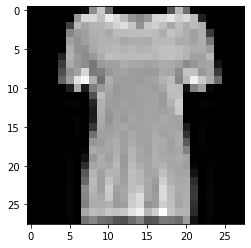

In [27]:
idx = 10
img, label = FashionMNIST(root=".", download= True)[idx]
show_image(img)

### Visualize Filters

In [28]:
###############################
# code by Tan Xi En  #
###############################

def visTensor(tensor, ch=0, allkernels = False, nrow=8, padding=1): 
    n, c, h, w = tensor.shape

    if allkernels: 
        tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: 
        tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

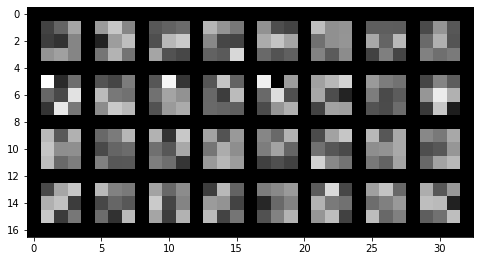

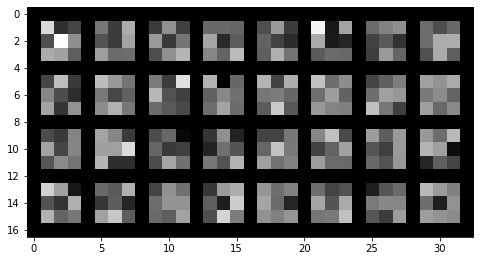

In [29]:
###############################
# code by Tan Xi En  #
###############################

# Get all the convolution from CNN + BN + Skip Connection Model
conv_layer = get_all_conv_layer_CNN(model3)

for (ind, conv2d) in enumerate(conv_layer):
    
    # Get weight of Each Convolution Layer
    wt = conv2d.state_dict()["weight"]

    # Plot Graph
    visTensor(wt)

### Visualize Feature Maps

Source Link: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [30]:
###############################
# code by Tan Xi En  #
###############################

# Convert Image to Tensor, then make it 4d array, similar to Batch Loader Shape [?, 1, 32, 32]
tmp = fashion_MNIST_transform(img).unsqueeze(0)
result = [tmp]

# Get all the convolution from CNN + BN + Skip Connection Model
conv_layer = get_all_conv_layer_CNN(model3)

# Let the sample image pass throught the convolution layers extracted from Model 3
for conv2d in conv_layer:
    result.append(conv2d(result[-1]))

torch.Size([1, 32, 32])
Feature Map 0


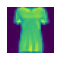

torch.Size([32, 32, 32])
Feature Map 1


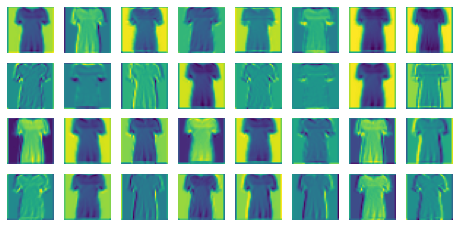

torch.Size([32, 32, 32])
Feature Map 2


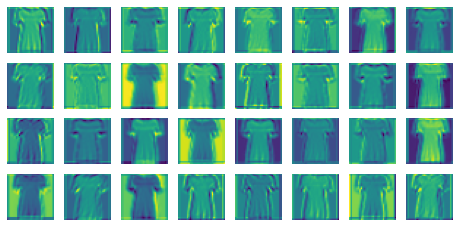

In [31]:
###############################
# code by Tan Xi En  #
###############################
ind = 0
for feature_map in result:
    plt.figure(figsize=(8, 8))
    layer_viz = feature_map[0, :, :, :].data # Get the first batch of the feature map
    print(layer_viz.size())
    print(f"Feature Map {ind}")
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter)
        plt.axis("off")
    plt.show()
    plt.close()
    ind += 1

### Visualize Grad-CAM Heatmap Activation

Grad-Cam Heatmap are a great way to visualize the regions that are focused by the Neural Network Model. This is done by computing the gradients and converting it into a heatmap. We then plot the heatmap, and may begin superimposing the image. Unfortunately, Fashion MNIST and our CNN model are trained on grayscale images. Therefore, superimposing heatmap will only make researchers more confused.

Source Link: https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82

In [32]:
###############################
# code by Tan Xi En  #
###############################

# Transform Image
tmp = fashion_MNIST_transform(img).unsqueeze(0)
result = [tmp]

gradient_arr = {}

In [35]:
###############################
# code by Tan Xi En  #
###############################

tmp = fashion_MNIST_transform(img).unsqueeze(0)
result = [tmp]

def hook_fn(m, i, o):
    gradient_arr[m] = o

conv_layer = get_all_conv_layer_CNN(model3)

for conv2d in conv_layer:
    result.append(conv2d(result[-1]))
    conv2d.register_forward_hook(hook_fn)

In [36]:
###############################
# code by Tan Xi En  #
###############################

gradient = gradient_arr[list(gradient_arr.keys())[-1]]
pooled_gradients = torch.mean(gradient, dim=[0, 2, 3])

activation = result[-1]

for i in range(32):
    activation[:, i, :, :] *= pooled_gradients[i]

In [37]:
###############################
# code by Tan Xi En  #
###############################

heatmap = torch.mean(gradient, dim= 1).squeeze().detach().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= heatmap.max()

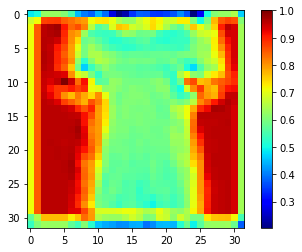

In [38]:
###############################
# code by Tan Xi En  #
###############################

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(heatmap, cmap = "jet")
fig.colorbar(cax)

In [39]:
tmp = fashion_MNIST_transform(img).unsqueeze(0)
outputs = model3(tmp)
_, predicted = torch.max(outputs, 1)
print(dataset.classes[predicted])

T-shirt/top
